In [1]:
!pip install tensorflow

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import SpatialDropout1D
import joblib

In [13]:
# Load cleaned dataset
df = pd.read_csv("liar_cleaned.csv")
df.head()

,label,statement,subject,speaker,speaker_job,state,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,context,binary_label
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,0
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,1


In [14]:
# Define features (statements) and labels
texts = df["statement"].astype(str).values  # Ensure text data is string
y = df["binary_label"].values

# Tokenization & Sequence Padding
max_words = 10000  # Vocabulary size
max_len = 100  # Max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split dataset into training (80%) and testing (20%)
# X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
# Build Optimized LSTM-GRU Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.3)),
    Bidirectional(GRU(64, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# # Build LSTM Model
# model = Sequential([
#     Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
#     Bidirectional(LSTM(64, return_sequences=True)),
#     Dropout(0.5),
#     Bidirectional(GRU(32)),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# Compile Model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

# Train Model
#history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/10


C:\Users\agmil\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 329ms/step - accuracy: 0.5445 - loss: 0.6882 - val_accuracy: 0.6075 - val_loss: 0.6756
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 298ms/step - accuracy: 0.6337 - loss: 0.6486 - val_accuracy: 0.6192 - val_loss: 0.6550
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 50s 312ms/step - accuracy: 0.7259 - loss: 0.5741 - val_accuracy: 0.5950 - val_loss: 0.6938
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 299ms/step - accuracy: 0.7856 - loss: 0.4916 - val_accuracy: 0.5833 - val_loss: 0.7422
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 303ms/step - accuracy: 0.8320 - loss: 0.4081 - val_accuracy: 0.5852 - val_loss: 0.8498


In [16]:
# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"LSTM-GRU Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
LSTM-GRU Model Accuracy: 0.6192
              precision    recall  f1-score   support

           0       0.59      0.45      0.51      1131
           1       0.63      0.75      0.69      1427

    accuracy                           0.62      2558
   macro avg       0.61      0.60      0.60      2558
weighted avg       0.61      0.62      0.61      2558



In [17]:
# Save Model & Tokenizer
model.save("fake_news_lstm_model.h5")
joblib.dump(tokenizer, "tokenizer.pkl")
print("LSTM-GRU model and tokenizer saved!")

LSTM-GRU model and tokenizer saved!


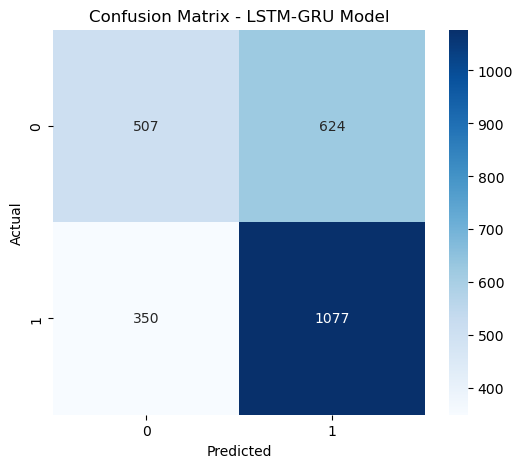

In [18]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM-GRU Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()